# Artificial Evolution

I want to be able to guess the best allele variants required to maximise a particular trait or traits. Evolution does this by... evolution. To do this I need to make a few assumptions that I believe are pretty fair assuptions to make.

1. Gene interactions are *not* too complex or impossible to model.
2. The phenotype of unseen genetype combinations can be estimated by a model.

In [1]:
import warnings
import numpy as np
import matplotlib.pyplot as graph
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
from ParticleSwarmOptimiser import swarm, evolve

warnings.simplefilter('ignore')
sns.set_style('ticks')
%matplotlib inline

def plot_3d_surfaces(func, x_range, y_range, step=0.1):
    fig = graph.figure(figsize=(9, 9))
    ax = fig.gca(projection='3d')

    xx, yy = np.meshgrid(np.arange(x_range[0], x_range[1], step), np.arange(y_range[0], y_range[1], step))
    zz = []
    for x, y, in zip(xx.ravel(), yy.ravel()):
        zz.append(func([x, y]))
    zz = np.array(zz).reshape(xx.shape)

    surface = ax.plot_surface(xx, yy, zz, cmap='jet')
    fig.show()

# The Evolutionary Algorithms

I expect the space to be search to be highly dimensional and non-linear. This means that evolution, even real evolution, has a potential problem that it may be incapable of solving. That is it gets stuck in a local optimal solution where the path to the best possible solution requires a decrease in fitness.

## Dealing with Non-linearity

For example this function has a global minimum that a classical continuous improvement only gradient descent algorithm could potentially fail to solve due to the local minimum that appears near the solution. 

$$f(x, y) = sin(\pi x) + {{x^2} \over 2} + sin(\pi y) + {{y^2} \over 2}$$

$$f(-0.453854, -0.453854)_{min} \approx -1.77304$$

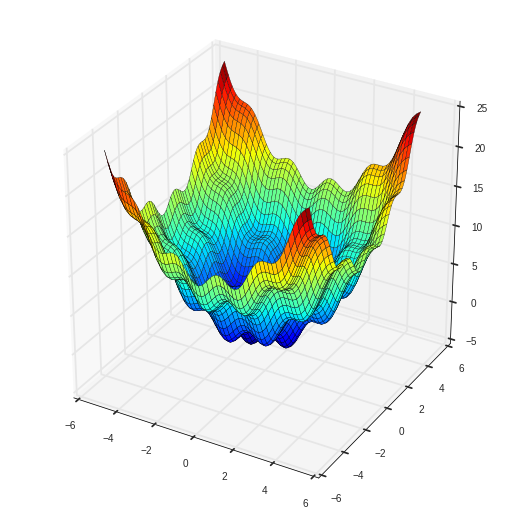

In [2]:
from costFunctions import complex_bowl

plot_3d_surfaces(complex_bowl, (-5, 5), (-5, 5), 0.02)

In [3]:
print('Solving Complex Bowl')
bowl_min, bowl_min_value = swarm(complex_bowl, bounds=[(-20, 20)] * 2)
print('z({}) = {}'.format(bowl_min, bowl_min_value))

Solving Complex Bowl
Stopping search: Swarm best objective change less than 1e-12
z([-0.45385389 -0.45385376]) = -1.7730364681285335


## Dealing with Slow Improvement

The selection process involved with evolution means that variation monotonically decreases and only mutation can add new variation. If the complex bowl was a function for real fitness the population's varitation would collapse to some small number and favorable mutations (which in this example would occur 25% of the time per individual) allows the population to slowly walk towards its goal. Since there were 100 individuals in the above population it was effectively ensured that each generation had at least 1 individual with a favorable mutation. 

This situation could be greatly improved if the population's variability was also taken into account to inform the individual's movements. That is an individual become more likely to make large steps if total population variability is low. Effectively allowing for 'Saltational Evolution' which may not be possible in real life.

To demonstrate this aspect I'll evolve the solution to this problem

$$f(x, y) = (a-x)^2 + b(y-x^2)^2$$
$$a = 1, b = 100$$
$$f_{min}(a, a^2) = 0$$

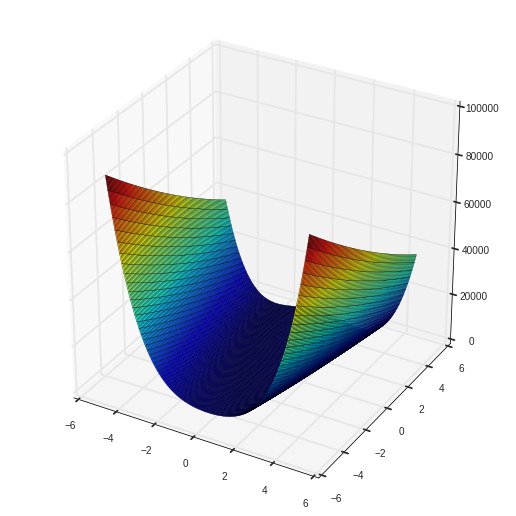

In [4]:
from costFunctions import rosenbrock_function

plot_3d_surfaces(rosenbrock_function, (-5, 5), (-5, 5), 0.01)

In [5]:
print('Solving Rosenbrock Function')
rosen_min, rosen_min_value = swarm(rosenbrock_function, bounds=[(-20, 20)] * 2)
print('z({}) = {}'.format(rosen_min, rosen_min_value))

Solving Rosenbrock Function
Stopping search: maximum iterations reached --> 100
z([ 0.9999747   0.99994949]) = 6.411055522480503e-10


## Dealing with High Dimensionality

High dimensionality just comes with the territory when dealing with genomics. We can do fantastic feature reduction by first finding the QTL and only optimising those. This still means that we would be dealing with maybe $>10$ even  greater $>50$ QTLs, since each QTL is a dimension this space could be very computationally expensive to solve. Evolution can still be used to solve this relatively quickly.

To demonstrate this I will evolve a perfect solution starting from random letters. The lenght of the string is the number of dimensions and each dimension has 126 possible states. Some aspects of the importance of this evolutionary strategy will become more apparent in this example. Recombination and Saltational Evolution in particular.

Target String is *'Stephen Anthony Rose I evolved from nothing'*
44 Dimensions

Probability of chancing upon the solution...
${1 \over {126^{44}}} \approx 0$

or

$${1 \over  260797837024638064790077928299789749433155058003146383333044805120010124148063654933352677376}$$

*So basically* you cannot guess it.

In [6]:
from costFunctions import string_match_score_function, generate_string_from_array

target_string = 'Stephen Anthony Rose I evolved from nothing'

print('String Evolution')
string_evolution = evolve(
    string_match_score_function, bounds=[(32, 126)] * len(target_string), args=(target_string, False)
)
print(string_evolution)
print('Translated Solution:', generate_string_from_array(string_evolution.x.tolist()))

String Evolution
     fun: 0.0
 message: 'Optimization terminated successfully.'
    nfev: 252239
     nit: 390
 success: True
       x: array([  82.58122617,  116.02897393,  100.87266932,  112.29403196,
        103.9709575 ,  100.9726637 ,  109.85273822,   32.17577162,
         64.98708435,  109.99126386,  115.75266027,  103.91393856,
        111.21030141,  109.84341983,  121.10285658,   32.28513003,
         81.95848727,  111.25449259,  115.25813834,  101.37375558,
         32.32323196,   73.08847167,   32.08537437,  101.36738053,
        117.75381229,  110.83517677,  107.99765447,  118.06930732,
        100.80598014,   99.67475862,   32.33888117,  102.08906748,
        113.74901118,  110.92244372,  109.2619925 ,   32.4011258 ,
        110.40442364,  110.8625885 ,  115.86660026,  103.56101131,
        105.41144157,  109.60603258,  102.70232986])
Translated Solution: Stephen Anthony Rose I evolved from nothing


**What the evolutionary process actually looked like**

In [7]:
quick_string = 'Stephen Rose'

string_evolution = evolve(
    string_match_score_function, bounds=[(32, 126)] * len(quick_string), args=(quick_string, True)
)
print('--- DONE ---\n')
print(generate_string_from_array(string_evolution.x.tolist()))

$x:2:<i28<ww
;ASq&wIM8SC)
%uI)SUb!or<X
<kj$\ur$vi^_
&YRj|v|$co^,
s}YoXina6*Bt
bhp'oUKr]8"6
MB4_vID0VcS-
GJ-uc_8Td&rs
TCU.J_ILpG/e
G3M-r59ifkg1
kvbaUkZxR*)%
#m\o<+i5gt\:
]j0]VuOwb]-%
Dy^j^"vxLWFT
A[&WGj.()Z[X
1g}`Aj&_Vl8u
c<t[F=GC|L\S
=+k6,Yk49'+O
h!oEwq%cL|&]
$gFUHgsh`f*d
/$NJRNYRN'G2
c6qXi*{z(RQ&
Fba]GD+c=%QK
IqZiLp+EKqRI
o]ET5Sa(<YNy
j=f6#62\)8hz
Fn9g-2u%6C|Q
wV$EodZ)Uv0(
eT2|OtSH/d3m
9O/vy<hZm1aD
|&5m|.A>D49^
Usg+s]%<$bd$
RG|_80cUd44k
n/glb:lH4:G4
mW71j6@{^x73
_#d0qhxs-+67
(r6?B[Q*}$OB
ulp3wL(W[},+
j#'e8I\^MOXa
_x_K)PjJ@wxq
.86&n!M/P9Yb
P9TC5EMs5X~M
\n]~}8>C3yGP
,L"}L$mFkDY<
N0Ay,R^Z#gw$
wfs){x-\z-PP
rM<yfH)B_J:D
-_Erxc^]z^#G
8U7?7h)~lIy]
F2i\bETNjQ)8
LGuI%U?!oW44
1NIK+obKysk&
M>uwlt[{Y03{
z9Mv`)$muP}F
T5Aae/X3 WJ>
QtS$70V|@St^
I`pe"r.dF=Aq
`bGkdlC#O;Ki
1`5dq,K6=Fq"
}s**tg4)GIKf
U;[kD;*1$,`E
K)FMzL6Yb[#R
Wh++r7Y?WaF,
OzVQN`=l_x>(
>f&(29` ro;Q
^m(sx?iFCt`m
~{VDMBcL27bj
=,e%`'oQ0mjx
V}2/C[N5,s-w
hL8xM}7?XCZl
HQ,Rh>\a^Uo 
{3%(9wRmFUw*
`Dxd!aAenL]}
k?Te`N,#,^&l
)E.""d/LTBd~
L1\Pi}`aL1q=